# Tutorial 6 - Termodinámica Avanzada

## Calculo de LLE LLE para una mezcla de fluidos usando PC-SAFT

En este tutorial se ilustran los cálculos de LLE con ```pcsaft``` EoS.

Primero, se importan todos los módulos necesarios.

- numpy: interfaz numérica y trabajo con arrays.
- matplotlib: para graficar resultados.
- ternario: traza gráficos ternarios en Python.
- epcsaftpy: paquete con la EoS
- sgtpy: paquete con funciones de equilibrio de fase.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ternary
from epcsaftpy import component, mixture, pcsaft
from sgtpy.equilibrium import flash

Ahora, los componentes puros se configuran y crean con la función ```component```. Luego, se crea una mezcla con ellos usando la función ```mixture``` o agregando (`+`) componentes puros. Los parámetros de interacción se configuran con el método ```mixture.pcsaft```. Finalmente, el objeto ```eos``` se crea con la función ```pcsaft```.

El objeto ```eos``` incluye todos los métodos necesarios para calcular equilibrios de fase y propiedades interfaciales usando PC-SAFT EoS.

Para este tutorial, todos los cálculos se ejemplifican para una mezcla de butanol, agua y hexano.

In [2]:
butanol = component('butanol', pure_path = 'parameters/solvents.json')
pentane = component('n-pentane', pure_path = 'parameters/gross2001.json')
MEG = component('meg', pure_path = 'parameters/hydrogen.json')
mix = butanol + pentane + MEG
eos = pcsaft(mix)

## Cálculo de LLE

Este tipo de cálculo de equilibrios se lleva a cabo para una composición global (z), temperatura (K) y presión (Pa) dadas. Este cálculo se puede realizar con la función ```flash``` o ```lle```.

El cálculo flash se lleva a cabo con la función ```flash``` y requiere valores iniciales para la composición de fases ```x0```, ```w0``` y su estado de agregación (```LL` `` para equilibrios líquido/líquido).

El ```lle``` requiere valores iniciales para la composición de fase ```x0``` y ```w0```.

La opción ```full_output``` permite obtener toda la información relacionada con el cálculo del LLE. Esto incluye el volumen de las fases y la solución para la fracción de los sitios no unidos de cada fase.

In [3]:
from sgtpy.equilibrium import lle
# phase equilibria conditions
T = 283.15  # K
P = 1.01325e5  # Pa
z = np.array([0.3, 0.6, 0.1])
# initial guesses
x0 = np.array([0.5, 0.2, 0.3])
w0 = np.array([0.05, 0.9, 0.05])
lle(x0, w0, z, T, P, eos, full_output=True)

           T: 283.15
           P: 101325.0
 error_outer: 0.00019113492718988355
 error_inner: 1.3722747697763804e-10
        iter: 25
        beta: array([0.37148562, 0.62851438])
       tetha: array([0.])
           X: array([[0.38590994, 0.45614154, 0.15794852],
       [0.24922263, 0.68502805, 0.06574932]])
           v: [9.503857406695861e-05, 0.0001041342783165288]
        Xass: [array([0.15455973, 0.15455973, 0.08515335, 0.08515335]), array([0.21292816, 0.21292816, 0.12090278, 0.12090278])]
      states: ['L', 'L']
      method: 'BFGS'

## Diagrama ternario a presión y temperatura constantes

Para calcular un diagrama LLE ternario, se recomienda calcular primero el LLE para los subsistemas binarios.

<!-- Luego, dependiendo del tipo de diagrama (con o sin punto crítico), puede generar una ruta de composición global para calcular el LLE. -->

In [4]:
n = 100 
X = np.zeros([3, n])
#pentane rich phase
x1 = np.array([0.0341, 0.0514, 0.0717, 0.1222, 0.1596, 0.1956, 0.2396])
x2 = np.array([0.9584, 0.9377, 0.9130, 0.8489, 0.7958, 0.7399, 0.6616])
x3 = np.array([0.0076, 0.0110, 0.0153, 0.0288, 0.0446, 0.0645, 0.0988])
#MEGA RICH PHASE
w1 = np.array([0.1475, 0.1730, 0.2071, 0.2579, 0.3038, 0.3357, 0.3536])
w2 = np.array([0.0163, 0.0202, 0.0341, 0.0612, 0.0853, 0.1164, 0.1756])
w3 = np.array([0.8362, 0.8068, 0.7588, 0.6810, 0.6109, 0.5479, 0.4708])
W = np.zeros([3, n])
vx = np.zeros(n)
vw = np.zeros(n)



In [5]:
i = n-1
z0 = np.array([0.45, 0.3, 0.25])
x0 = np.array([0.66, 0.09, 0.25])
w0 = np.array([0.175, 0.425, 0.4])

sol = lle(x0, w0, z0, T, P, eos, full_output=True)
X[:, i], W[:, i] = sol.X
vx[i], vw[i] = sol.v
sol

           T: 283.15
           P: 101325.0
 error_outer: 3.891617924311572e-05
 error_inner: 0.7557481204411631
        iter: 25
        beta: array([0., 1.])
       tetha: array([0.])
           X: array([[0.45105635, 0.23731052, 0.31163313],
       [0.4504547 , 0.2730158 , 0.2765295 ]])
           v: [8.454250759995444e-05, 8.659004375544768e-05]
        Xass: [array([0.12029387, 0.12029387, 0.06518726, 0.06518726]), array([0.12536643, 0.12536643, 0.06809819, 0.06809819])]
      states: ['L', 'L']
      method: 'ASS'

In [6]:
# generando ruta de composición global (Z)
i = 0
z0 = (X[:, i] + W[:, i])/2
i = -1
z1 = (X[:, i] + W[:, i])/2
print(z0)
Zs = np.linspace(z0, z1, n)

# calcular LLE utilizando composiciones y volúmenes calculados previamente como conjeturas iniciales
for i in range(1, n-1):
    sol = lle(X[:, i-1], W[:, i-1], Zs[i], T, P, eos, v0=[vx[i-1], vw[i-1]], full_output=True)
    X[:, i], W[:, i] = sol.X
    vx[i], vw[i] = sol.v
    # print(i, sol.error_outer, sol.error_inner, sol.tetha, sol.iter)

[0. 0. 0.]


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\epcsaftpy\pcsaft_mixtures\pcsaftmix.py:1100: RuntimeWarning: divide by zero encountered in scalar divide
  rho0 = 1./v0
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\epcsaftpy\pcsaft_mixtures\pcsaftmix.py:815: RuntimeWarning: divide by zero encountered in scalar divide
  rhomax /= np.dot(x, (self.ms * np.pi * self.sigma**3))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\epcsaftpy\pcsaft_mixtures\ares.py:260: RuntimeWarning: invalid value encountered in divide
  xs = xmi / xm
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\epcsaftpy\pcsaft_mixtures\ares.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  xhi = xhi00 * xm * np.matmul(xs, di03)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\epcsaftpy\pcsaft_mixtures\dispersion\adisp.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  

LinAlgError: Array must not contain infs or NaNs.

Los resultados se grafican a continuación utilizando el paquete ``Ternary``

(0.1475, 0.0163, 0.8362)
(0.173, 0.0202, 0.8068)
(0.2071, 0.0341, 0.7588)
(0.2579, 0.0612, 0.681)
(0.3038, 0.0853, 0.6109)
(0.3357, 0.1164, 0.5479)
(0.3536, 0.1756, 0.4708)


(-0.05, 1.05, -0.1, 0.9)

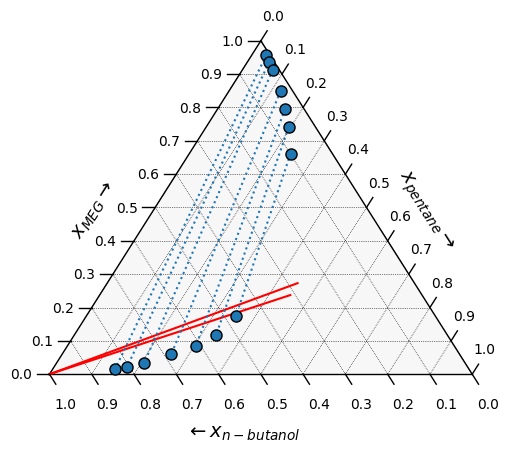

In [ ]:
fig = plt.figure(figsize = (6,5))

fontsize = 14
ax3 = fig.add_subplot(111)
tax = ternary.TernaryAxesSubplot(ax=ax3, scale = 1.0)
tax.boundary(linewidth=1.0)
tax.gridlines(color="black", multiple=0.1, linewidth=0.5)

tax.plot(X.T, color = "r")
tax.plot(W.T, color = "r")
# tax.plot(Zs, color = "b")

nE = len(x1)

for i in range(nE):
     p1 = (x1[i], x2[i], x3[i])
     p2 = (w1[i], w2[i], w3[i])
     print(p2)
     tax.line(p1, p2, linewidth = 1.5, markersize = 8, markeredgewidth = 1, markeredgecolor = "black",  marker = "o", linestyle = ":")
           

for i in range(0, n, 10):
    tax.plot([X[:, i], W[:, i]], linestyle='--', color='k')

tax.ticks(clockwise=True, multiple=0.1, linewidth=1, offset = 0.03,tick_formats='%.1f')


#Set labels
tax.right_axis_label(r"$x_{pentane}\rightarrow$", fontsize=fontsize, offset = 0.15)
tax.left_axis_label(r"$x_{MEG} \rightarrow$", fontsize=fontsize, offset = 0.15)
tax.bottom_axis_label(r"$\leftarrow x_{n-butanol}$", fontsize=fontsize, offset = 0.15)


# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax._redraw_labels()
ternary.plt.axis('off')
#fig.savefig('lle-ternary.pdf')

In [ ]:
 # Experimental tie-line

    nE = len(x1E)

    for i in range(nE):

        p1 = (x1E[i], x2E[i], x3E[i])

        p2 = (w1E[i], w2E[i], w3E[i])

        tax.line(p1, p2, linewidth = 1.5, markersize = 8, 

                 markeredgewidth = 1, markeredgecolor = "black", 

                 marker = "o", color = colorEXP, linestyle = ":")
 

    data = pd.read_excel('data_exp/LLE_water_FA_DES.xlsx', name_DES)

    w1E, w2E, w3E = np.array(data.iloc[:,[0,1,2]]).T

    x1E, x2E, x3E = np.array(data.iloc[:,[3,4,5]]).T

In [ ]:
def Gfcn(x, T, P):
    x = np.array(x)
    mu = saft.muad(x T, P)
    return np.dot(x, mu)
n = 100
xzero = 1e-8
xi = np. linspace(xzero, 1 - xzero, n)

# Análisis binario 1-2
x3 = 0
g1 = Gfcn([1, 0, 0], T, P)
g2 = Gfcn([1, 0, 0], T, P)
dg = np.zeros(n)
for i in range(n):
    g = Gfcn([xi[i], 1-xi[i], x3], T, P)
    dg[i] = g - xi[i]*g1 - (1 - xi[i])*g2
    
plt.figure()
plt.plot(xi, dg, "r")
plt.xlim(0,1)
plt.show()